## 0. Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import kpss
#from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_sarimax
from skforecast.model_selection import grid_search_sarimax


import time
import itertools
import warnings
import statsmodels.api as sm


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Import data

In [2]:
df_total_payments = pd.read_csv("../Datasets/clean_total_payments.csv", index_col=0)
df_purchase_orders = pd.read_csv("../Datasets/clean_purchase_orders.csv", index_col=0)
df_customer = pd.read_csv("../Datasets/clean_customer.csv", index_col=0)
df_employees = pd.read_csv("../Datasets/clean_employees.csv", index_col=0)
df_inventory = pd.read_csv("../Datasets/clean_inventory.csv", index_col=0)
df_order_details = pd.read_csv("../Datasets/clean_order_details.csv", index_col=0)
df_orders = pd.read_csv("../Datasets/clean_orders.csv", index_col=0)
df_products = pd.read_csv("../Datasets/clean_products.csv", index_col=0)
df_order_payment = pd.read_csv("../Datasets/clean_order_payment.csv", index_col=0)

In [3]:
df_orders.head()

,OrderID,CustomerID,EmployeeID,ShippingMethodID,OrderDate,ShipDate,FreightCharge,DeliveryTime,OrderYear,OrderMonth
0,2,1,1,1,2003-07-10,2003-07-10,0.0,0,2003,7
1,4,2,2,1,2003-07-11,2003-07-11,0.0,0,2003,7
2,5,2,1,1,2003-07-15,2003-07-15,0.0,0,2003,7
3,6,3,1,1,2003-07-14,2003-07-14,0.0,0,2003,7
4,7,4,1,1,2003-07-14,2003-07-15,0.0,1,2003,7


In [4]:
df_order_details.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price
0,2,2,955,5,7.5,37.5
1,3,2,958,5,8.5,42.5
2,5,2,959,5,8.5,42.5
3,6,4,72,50,3.0,150.0
4,7,4,9,50,3.2,160.0


In [5]:
df_products.head()

,ProductID,ProductName,ModelDescription,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,1,3-182,AT,Undershirts,Girls' Undershirts,Underwear,822,M,Dozen,In Production,2003-07-10,6.6,182
1,2,3-183,AT,Undershirts,Girls' Undershirts,Underwear,620,M,Dozen,Out of Production,2003-07-10,5.6,183
2,3,3-184,AT,Undershirts,Girls' Undershirts,Underwear,718,M,Dozen,In Production,2003-07-10,6.3,184
3,4,3-185,AT,Undershirts,Boys' Undershirts,Underwear,820,M,Dozen,In Production,2003-07-10,5.6,185
4,5,3-A30N,A,Briefs,Girls' Panties,Underwear,214,M,Dozen,Out of Production,2003-08-06,3.3,A30N


Merge data

In [6]:
df = pd.merge(df_order_details, df_orders, on = 'OrderID')
df = pd.merge(df, df_products, on = 'ProductID')
df.head()

,OrderDetailID,OrderID,ProductID,QuantitySold,UnitSalesPrice,total_price,CustomerID,EmployeeID,ShippingMethodID,OrderDate,...,Category,Gender,ProductLine,Weight,Size,PackSize,Status,InventoryDate,PurchasePrice,ProductType
0,2,2,955,5,7.5,37.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,997,XXL,Dozen,In Production,2003-07-10,7.15,PCL29
1,3,2,958,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1110,XXL,Dozen,In Production,2003-07-10,8.30,PCL31S
2,5,2,959,5,8.5,42.5,1,1,1,2003-07-10,...,Drawers,Women's Panties,Underwear,1055,XXL,Dozen,In Production,2003-07-10,7.20,PCL31T
3,6,4,72,50,3.0,150.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,233,S,Dozen,In Production,2003-07-10,2.50,ERK61
4,7,4,9,50,3.2,160.0,2,2,1,2003-07-11,...,Briefs,Boys' Briefs,Underwear,325,M,Dozen,In Production,2003-07-10,2.70,ERK61


In [7]:
df.dtypes

OrderDetailID         int64
OrderID               int64
ProductID             int64
QuantitySold          int64
UnitSalesPrice      float64
total_price         float64
CustomerID            int64
EmployeeID            int64
ShippingMethodID      int64
OrderDate            object
ShipDate             object
FreightCharge       float64
DeliveryTime          int64
OrderYear             int64
OrderMonth            int64
ProductName          object
ModelDescription     object
Category             object
Gender               object
ProductLine          object
Weight                int64
Size                 object
PackSize             object
Status               object
InventoryDate        object
PurchasePrice       float64
ProductType          object
dtype: object

In [13]:
# Convert date to datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

df.dtypes

OrderDetailID                int64
OrderID                      int64
ProductID                    int64
QuantitySold                 int64
UnitSalesPrice             float64
total_price                float64
CustomerID                   int64
EmployeeID                   int64
ShippingMethodID             int64
OrderDate           datetime64[ns]
ShipDate                    object
FreightCharge              float64
DeliveryTime                 int64
OrderYear                    int64
OrderMonth                   int64
ProductName                 object
ModelDescription            object
Category                    object
Gender                      object
ProductLine                 object
Weight                       int64
Size                        object
PackSize                    object
Status                      object
InventoryDate               object
PurchasePrice              float64
ProductType                 object
dtype: object

## 2. Tendecy total sales

In [16]:
sales = df.groupby(['OrderDate'])['QuantitySold'].sum().reset_index()
sales

,OrderDate,QuantitySold
0,2003-07-10,145
1,2003-07-11,330
2,2003-07-14,768
3,2003-07-15,835
4,2003-07-16,540
...,...,...
741,2006-04-13,2044
742,2006-04-14,92
743,2006-04-18,147
744,2006-04-19,4145


In [17]:
y = sales.set_index('OrderDate')
y = y.asfreq('W-MON')
y = y['QuantitySold']
y

OrderDate
2003-07-14     768.0
2003-07-21     180.0
2003-07-28     614.0
2003-08-04     573.0
2003-08-11     375.0
               ...  
2006-03-20      46.0
2006-03-27      25.0
2006-04-03    1080.0
2006-04-10     468.0
2006-04-17       NaN
Freq: W-MON, Name: QuantitySold, Length: 145, dtype: float64

In [18]:
mean_value = sales['QuantitySold'].mean()
mean_value

np.float64(910.4718498659518)

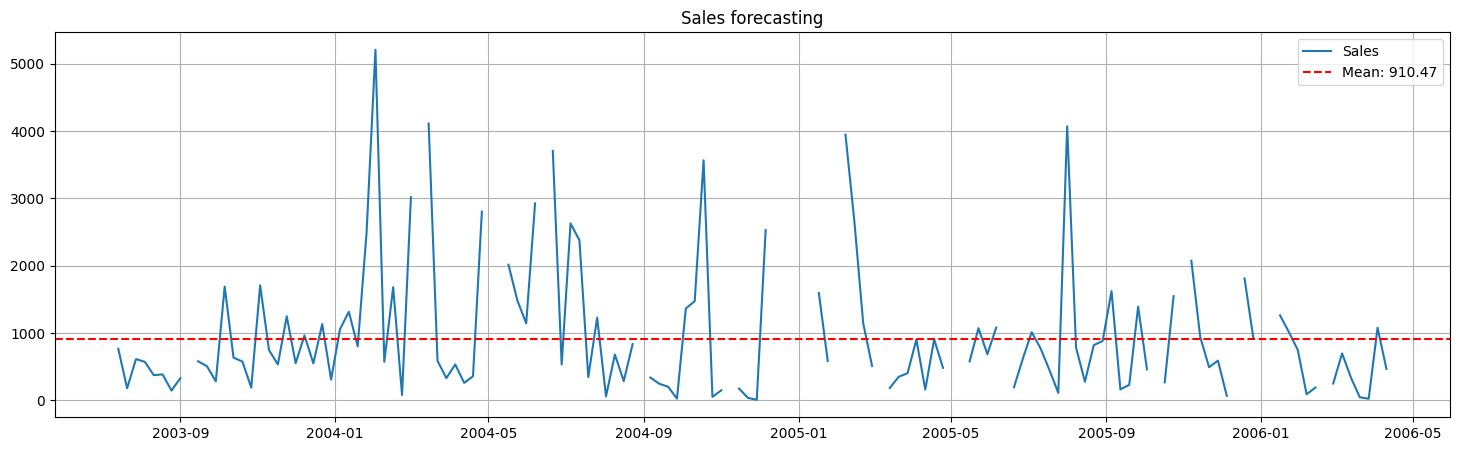

In [20]:
plt.figure(figsize=(18,5))
plt.plot(y, linestyle="-", label = 'Sales')
plt.axhline(y=mean_value, color='r', linestyle="--", label=f"Mean: {mean_value:.2f}")
plt.title('Sales forecasting')
plt.legend()
plt.grid()
plt.show()



### 2.1 Comprobación de la estacionalidad de la serie

Existen varios métodos para evaluar si una serie temporal es estacionaria o no estacionaria:

- *Inspección visual de la serie temporal:* inspeccionando visualmente el gráfico de la serie temporal, es posible identificar la presencia de una tendencia o estacionalidad notables. Si se observan estos patrones, es probable que la serie no sea estacionaria.

- *Valores estadísticos: calcular estadísticos como la media y la varianza*, de varios segmentos de la serie. Si existen diferencias significativas, la serie no es estacionaria.

- *Pruebas estadísticas:* utilizar test estadísticos como la prueba Dickey-Fuller aumentada o la prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

El gráfico generado en el apartado anterior, nos muestra que hay una cierta estacionalidad con subidas y bajadas lo que tiende a indicar su estacionalidad. 


**Prueba de Dickey-Fuller aumentada**

La prueba Dickey-Fuller aumentada considera como hipótesis nula que la serie temporal tiene una raíz unitaria, una característica frecuente de las series temporales no estacionarias. Por el contrario, la hipótesis alternativa (bajo la cual se rechaza la hipótesis nula) es que la serie es estacionaria.

## **Contraste de Hipótesis para la Estacionariedad**

Queremos contrastar la siguiente hipótesis nula y alternativa usando la prueba de **Dickey-Fuller Aumentada (ADF):**

$$
H_0: \text{La serie tiene una raíz unitaria (No es estacionaria)}
$$

$$
H_1: \text{La serie es estacionaria}
$$



El valor crítico al 5% de significancia es:

$$
\text{Valor crítico} = -2.89
$$

Dado que la hipótesis nula supone la presencia de una raíz unitaria, el p-value obtenido debe ser inferior a un nivel de significación determinado, a menudo fijado en 0.05, para rechazar esta hipótesis. Este resultado indica la estacionariedad de la serie. La función `` adfuller()`` de la biblioteca Statsmodels permite aplicar la prueba ADF. Su resultado incluye cuatro valores: el p-value, el valor del estadístico, el número de retardos (lags) incluidos en la prueba y los umbrales del valor crítico para tres niveles diferentes de significancia.



In [74]:
result = adfuller(y)

stadistic_adf = result[0]
p_valor = result[1]

print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
print("Valor estadistico de ADF: {}\n".format(stadistic_adf))
    
print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
print("p-valor: {}\n".format(p_valor))

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -5.587610069110687

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.3517280752951798e-06





Tras aplicar la prueba **Dickey-Fuller Aumentada (ADF):**

$$
H_0: \text{La serie tiene una raíz unitaria (No es estacionaria)}
$$

$$
H_1: \text{La serie es estacionaria}
$$

El estadístico de prueba es:

$$
\text{ADF} = -5.59
$$

El valor crítico al 5% de significancia es:

$$
\text{Valor crítico} = -2.89
$$

El p-valor obtenido es:

$$
p = 1.35 \times 10^{-6}
$$

Dado que el **estadístico de ADF es menor que el valor crítico** y el **p-valor es menor que 0.05**, rechazamos la hipótesis nula $ H_0 $ y concluimos que la serie es **estacionaria**.


La prueba **KPSS** comprueba si una serie temporal es estacionaria en torno a una media o una tendencia lineal. En esta prueba, la hipótesis nula es que la serie es estacionaria. Por consiguiente, los p-values pequeños (por ejemplo, inferiores a 0.05) rechazan la hipótesis nula y sugieren que es necesario diferenciar. La librería Statsmodels proporciona una implementación de la prueba KPSS a través de la función ``kpss()``.

In [75]:
kpss_result = kpss(y)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

KPSS Statistic: 0.5198717389245547, p-value: 0.03719104979176695


Test estacionariedad serie original
-------------------------------------
ADF Statistic: -5.587610069110687, p-value: 1.3517280752951798e-06
KPSS Statistic: 0.5198717389245547, p-value: 0.03719104979176695

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -15.04940497177519, p-value: 9.341282472295002e-28
KPSS Statistic: 0.06449118491323948, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -15.04940497177519, p-value: 9.341282472295002e-28
KPSS Statistic: 0.1150530821805579, p-value: 0.1


C:\Users\Carlota\AppData\Local\Temp\ipykernel_9816\2740122371.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(y.diff().dropna())
C:\Users\Carlota\AppData\Local\Temp\ipykernel_9816\2740122371.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(y.diff().diff().dropna())


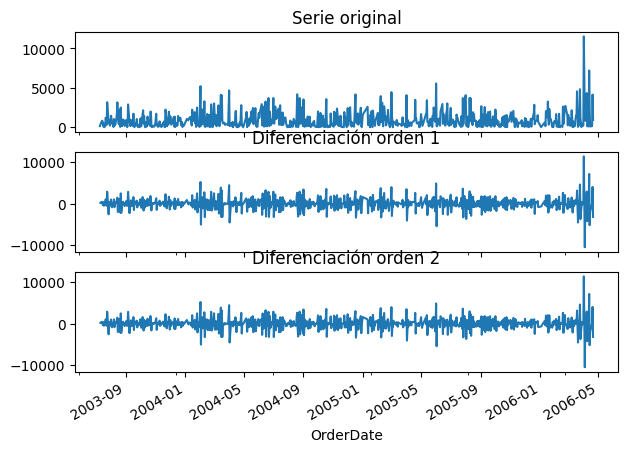

In [76]:
datos_diff_1 = y.diff().dropna()
datos_diff_2 = y.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(y)
kpss_result = kpss(y)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(y.diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(y.diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')


# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
y.plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

Estudiando los resultados obtenidos, podemos decir que:

1. **Serie original**

- *ADF Statistic*: -5.59, $\text{p_value}: 1.35 \times 10^{-6} --> la serie **es estacionaria** (se rechaza $H_0$)
- *KPSS Statistic*: 0.52, $\text{p_value}: 0.037 --> la serie ** no es estacionaria** (se rechaza $H_0$)

--> Esto indica que la serie puede ser **débilmente estacionaria pero con cierta tendencia o heterocedasticidad**

2. **Serie diferenciada (Orden 1)**

- *ADF Statistic*: -15.05, $\text{p_value}: 9.34 \times 10^{-28} --> la serie **es estacionaria** (se rechaza $H_0$)
- *KPSS Statistic*: 0.64, $\text{p_value}: 0.1 --> la serie ** es estacionaria** (no se rechaza $H_0$)

--> Esto indica que la serie es **estacionaria**

3. **Serie diferenciada (Orden 2)**

- *ADF Statistic*: -15.05, $\text{p_value}: 9.34 \times 10^{-28} --> la serie **es estacionaria** (se rechaza $H_0$)
- *KPSS Statistic*: 0.115, $\text{p_value}: 0.1 --> la serie ** es estacionaria** (no se rechaza $H_0$)

--> Esto indica que la serie es **estacionaria**

Por tanto, basta con una diferenciación para tener la serie estacionaria

**DIFERENCIACIÓN**

In [77]:
datos_diff_1

OrderDate
2003-07-11     185.0
2003-07-14     438.0
2003-07-15      67.0
2003-07-16    -295.0
2003-07-17    -425.0
               ...  
2006-04-13   -5157.0
2006-04-14   -1952.0
2006-04-18      55.0
2006-04-19    3998.0
2006-04-20   -3192.0
Name: QuantitySold, Length: 745, dtype: float64

## **Análisis de autocorrelación**

El gráfico de la función de autocorrelación *(Autocorrelation Function ACF)* y la función de autocorrelación parcial *(Partial Autocorrelation Function (PACF))* de la serie temporal proporciona información útil sobre los posibles valores adecuados de  $p$ y  $q$. La ACF ayuda a identificar el valor de  $q$ (retardos en la parte de media móvil), mientras que la PACF ayuda a identificar el valor de $p$ (retardos en la parte autorregresiva).

**Función de autocorrelación (*ACF*)**

La ACF calcula la correlación entre una serie temporal y sus valores retardados (lags). En el contexto de la modelización ARIMA, una caída brusca de la ACF después de unos pocos retardos indica que los datos tienen un orden autorregresivo finito. El retardo en el que cae la ACF proporciona una estimación del valor de $q$. Si el ACF muestra un patrón sinusoidal o sinusoidal amortiguado, sugiere la presencia de estacionalidad y requiere la consideración de órdenes estacionales además de órdenes no estacionales.


**Función de autocorrelación parcial (*PACF*)**

La PACF mide la correlación entre un valor retardado (lag) y el valor actual de la serie temporal, teniendo en cuenta el efecto de los retardos intermedios. En el contexto de la modelización ARIMA, si la PACF se corta bruscamente después de un determinado retardo, mientras que los valores restantes están dentro del intervalo de confianza, sugiere un modelo AR de ese orden. El desfase en el que se corta el PACF da una idea del valor de $p$.



Algunas reglas generales son:

- Utilizar un orden del término AR p igual al numero de *lags* que cruzan el límite de significancia en el gráfico PACF.
- Utilizar un orden del término MA q igual al numero de *lags* que cruzan el límite de significancia en el gráfico ACF.
- Si el ACF corta en el lag q y el PACF corta en el lag p, se recomienda empezar con un modelo ARIMA(p, d, q).
- Si sólo el PACF decae después del lag p, se recomienda empezar con un modelo AR(p).
- Si sólo el ACF decae después del lag q, se recomienda empezar con un modelo MA(q).


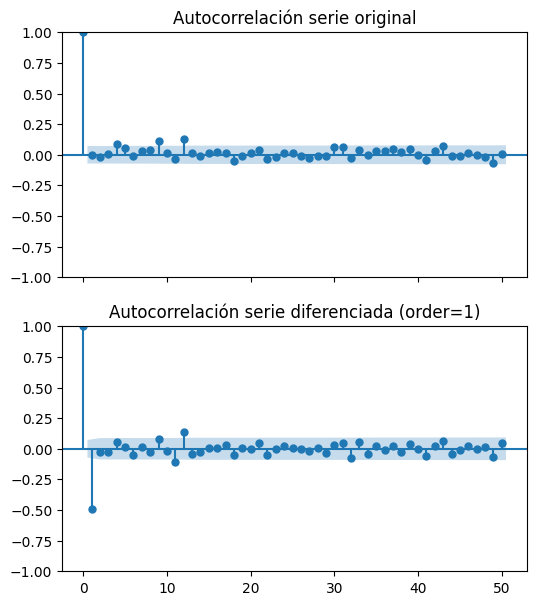

In [79]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7), sharex=True)
plot_acf(y, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

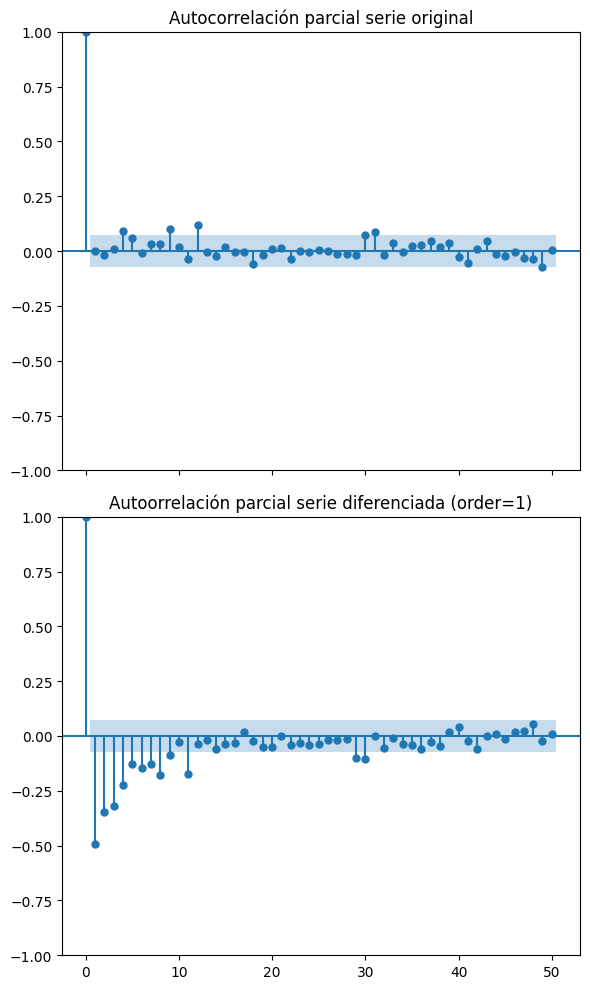

In [81]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 10), sharex=True)
plot_pacf(y, ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autoorrelación parcial serie diferenciada (order=1)');
plt.tight_layout();

## **Modelo ARIMA-SARIMAX**

Varias librerías de Python implementan modelos ARIMA-SARIMAX. Cuatro de ellas son:

- statsmodels

- pmdarima

- skforecast

In [109]:
train_size = int(len(y) * 0.8)

data_train = y[:train_size]
data_test = y[train_size:]



In [105]:
datos_diff_1_train = data_train.diff().dropna()
datos_diff_1_test = data_test.diff().dropna()

In [106]:
data_train

OrderDate
2003-07-10     145
2003-07-11     330
2003-07-14     768
2003-07-15     835
2003-07-16     540
              ... 
2005-09-09    2554
2005-09-10     520
2005-09-12     164
2005-09-13    1622
2005-09-14     108
Name: QuantitySold, Length: 596, dtype: int64

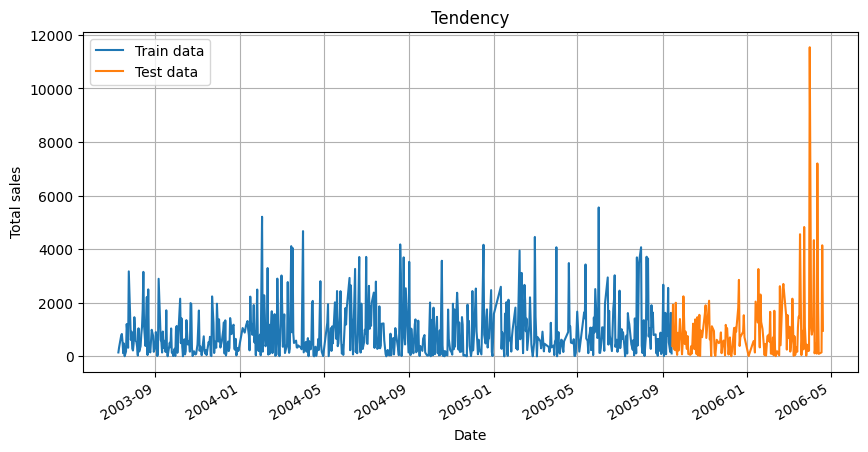

In [107]:
plt.figure(figsize=(10,5))
data_train.plot(label = 'Train data')
data_test.plot(label = 'Test data')
plt.legend(loc='best')
plt.title('Tendency')
plt.ylabel('Total sales')
plt.xlabel('Date')
plt.grid()
plt.show()

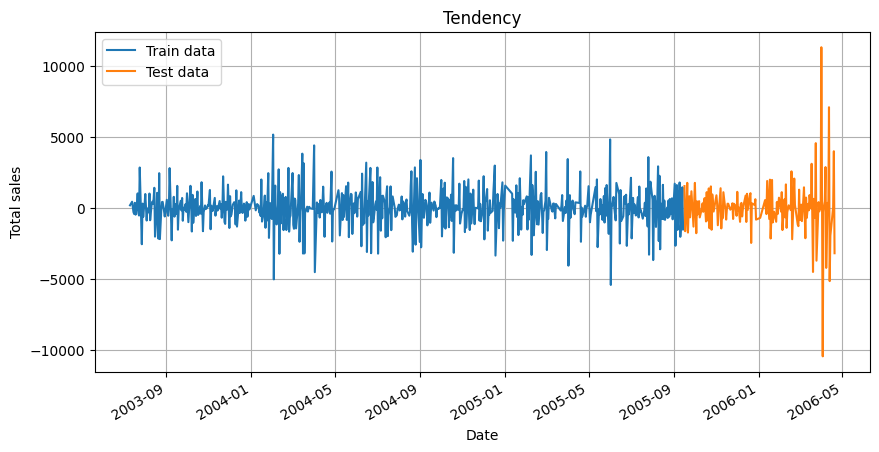

In [108]:
plt.figure(figsize=(10,5))
datos_diff_1_train.plot(label = 'Train data')
datos_diff_1_test.plot(label = 'Test data')
plt.legend(loc='best')
plt.title('Tendency')
plt.ylabel('Total sales')
plt.xlabel('Date')
plt.grid()
plt.show()

**statsmodels**

In [116]:
p, d, q = 1,0,1

model = SARIMAX(endog = data_train, order = (p, d, q), seasonal_order = (1, 1, 1, 12))
model_res = model.fit(disp=0)
model_res.summary()

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       QuantitySold   No. Observations:                  596
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -4859.788
Date:                            Tue, 18 Feb 2025   AIC                           9729.577
Time:                                    21:08:15   BIC                           9751.426
Sample:                                         0   HQIC                          9738.093
                                            - 596                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9989      0.432      2.312      0.021       0.152       1.846
ma.L1         -0.9990      0.440     -2.273      0.023      -1.860      -0.138
ar.S.L12       0.1077      0.042      2.576      0.010       0.026       0.190
ma.S.L12      -0.9958      0.189     -5.267      0.000      -1.366      -0.625
sigma2      9.367e+05   1.82e+05      5.144      0.000     5.8e+05    1.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               472.39
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             1.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El resumen del modelo muestra mucha información sobre el proceso de ajuste:

- Estadísticas de Ajuste del Modelo: Esta parte incluye varias estadísticas que ayudan a evaluar qué tan bien el modelo se ajusta a los datos observados:

    - Log-Likelihood (Logaritmo de la Verosimilitud): Una medida de qué tan bien el modelo explica los datos observados, donde valores más negativos indican un ajuste deficiente a los datos y valores más cercanos a cero indican un mejor ajuste.

    - AIC (Criterio de Información de Akaike): Una métrica de bondad de ajuste que equilibra el ajuste del modelo con su complejidad. Cuanto menor el valor de AIC mejor es el modelo.

    - BIC (Criterio de Información Bayesiano): Similar al AIC, pero penaliza más la complejidad del modelo. Al igual que con el AIC, valores más bajos de BIC indican un mejor ajuste.

    - HQIC (Criterio de Información de Hannan-Quinn): Otro criterio de selección de modelo, similar al AIC y al BIC.

- Coeficientes: Esta tabla lista los coeficientes estimados para los parámetros del modelo. Incluye tanto los parámetros autoregresivos (AR) como los parámetros de media móvil (MA), así como cualquier variable exógena si se incluyen en el modelo. También incluye los errores estándar asociados con los coeficientes estimados para indicar la incertidumbre de dichas estimaciones, sus p-values, que se utilizan para evaluar la significancia de cada coeficiente, y el intervalo de confianza del 95%.

- Diagnósticos del modelo: Esta sección proporciona información sobre los residuos. Las diferencias entre los valores observados (valores de entrenamiento) y los valores predichos por el modelo.

    - Prueba Ljung-Box: Una prueba de autocorrelación en los residuos.

    - Prueba de Jarque-Bera: Una prueba de normalidad de los residuos.

    - Asimetría y curtosis: Medidas de la forma de la distribución de los residuos.

In [117]:
predicciones_statsmodels = model_res.get_forecast(steps=len(data_test)).predicted_mean
predicciones_statsmodels.name = 'predicciones_statsmodels'
display(predicciones_statsmodels.head(4))

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


596     842.493698
597    1068.540883
598     782.811122
599    1114.008424
Name: predicciones_statsmodels, dtype: float64

In [120]:
predicciones_statsmodels, data_test

(596     842.493698
 597    1068.540883
 598     782.811122
 599    1114.008424
 600     728.629422
           ...     
 741     875.063122
 742     876.149525
 743    1052.577318
 744     807.347106
 745     784.272692
 Name: predicciones_statsmodels, Length: 150, dtype: float64,
 OrderDate
 2005-09-15     385
 2005-09-16    1926
 2005-09-17     287
 2005-09-19     231
 2005-09-20    2000
               ... 
 2006-04-13    2044
 2006-04-14      92
 2006-04-18     147
 2006-04-19    4145
 2006-04-20     953
 Name: QuantitySold, Length: 150, dtype: int64)

In [125]:
error = predicciones_statsmodels - data_test.values
error

596     457.493698
597    -857.459117
598     495.811122
599     883.008424
600   -1271.370578
          ...     
741   -1168.936878
742     784.149525
743     905.577318
744   -3337.652894
745    -168.727308
Name: predicciones_statsmodels, Length: 150, dtype: float64

<Axes: >

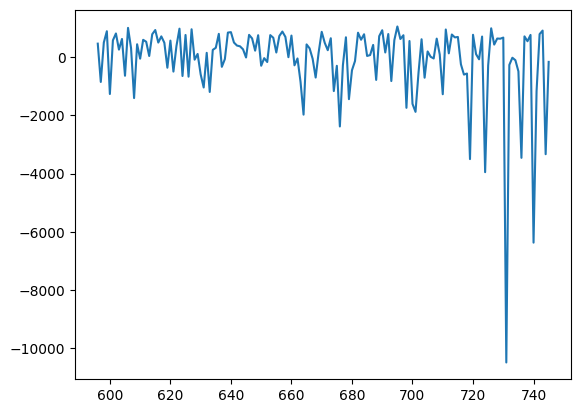

In [126]:
error.plot()

GridSearch

In [136]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


In [143]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(data_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:10232.071214135936
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:10131.162543625078
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:10071.350234603735
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:10250.253029493755
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:9839.918133266056
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:9822.452254587275


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:10882.75525487938
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:10228.387620552814


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:9900.773365033714
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:10085.406675960092
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:9859.749491282517


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:9838.754467863477
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:10085.518098658398
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:9841.706422464405


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:9822.629512567775
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:10548.225991915835
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:10084.8937328659


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:9887.781696457354
ARIMA(2, 0, 0)x(0, 0, 0, 0)12 - AIC:10010.467316996695


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(2, 0, 1)x(0, 0, 0, 0)12 - AIC:9861.77269263037


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:9838.987835950698
ARIMA(2, 1, 0)x(0, 0, 0, 0)12 - AIC:9992.804061031937


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(2, 1, 1)x(0, 0, 0, 0)12 - AIC:9834.67103407092


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2)x(0, 0, 0, 0)12 - AIC:9824.490831057408
ARIMA(2, 2, 0)x(0, 0, 0, 0)12 - AIC:10371.547939722586


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has 

ARIMA(2, 2, 1)x(0, 0, 0, 0)12 - AIC:10032.67208201012


c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 2, 2)x(0, 0, 0, 0)12 - AIC:9879.234195888283
La búsqueda de parámetros no ha llevado 0.0694038987159729 minutos!


In [144]:
mod = sm.tsa.statespace.SARIMAX(data_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carlota\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [145]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9950      0.053    -18.629      0.000      -1.100      -0.890
ma.L2          0.0079      0.053      0.149      0.881      -0.096       0.112
sigma2      1.055e+06   4.77e+04     22.109      0.000    9.61e+05    1.15e+06


el valor ma.L1 no es significativo

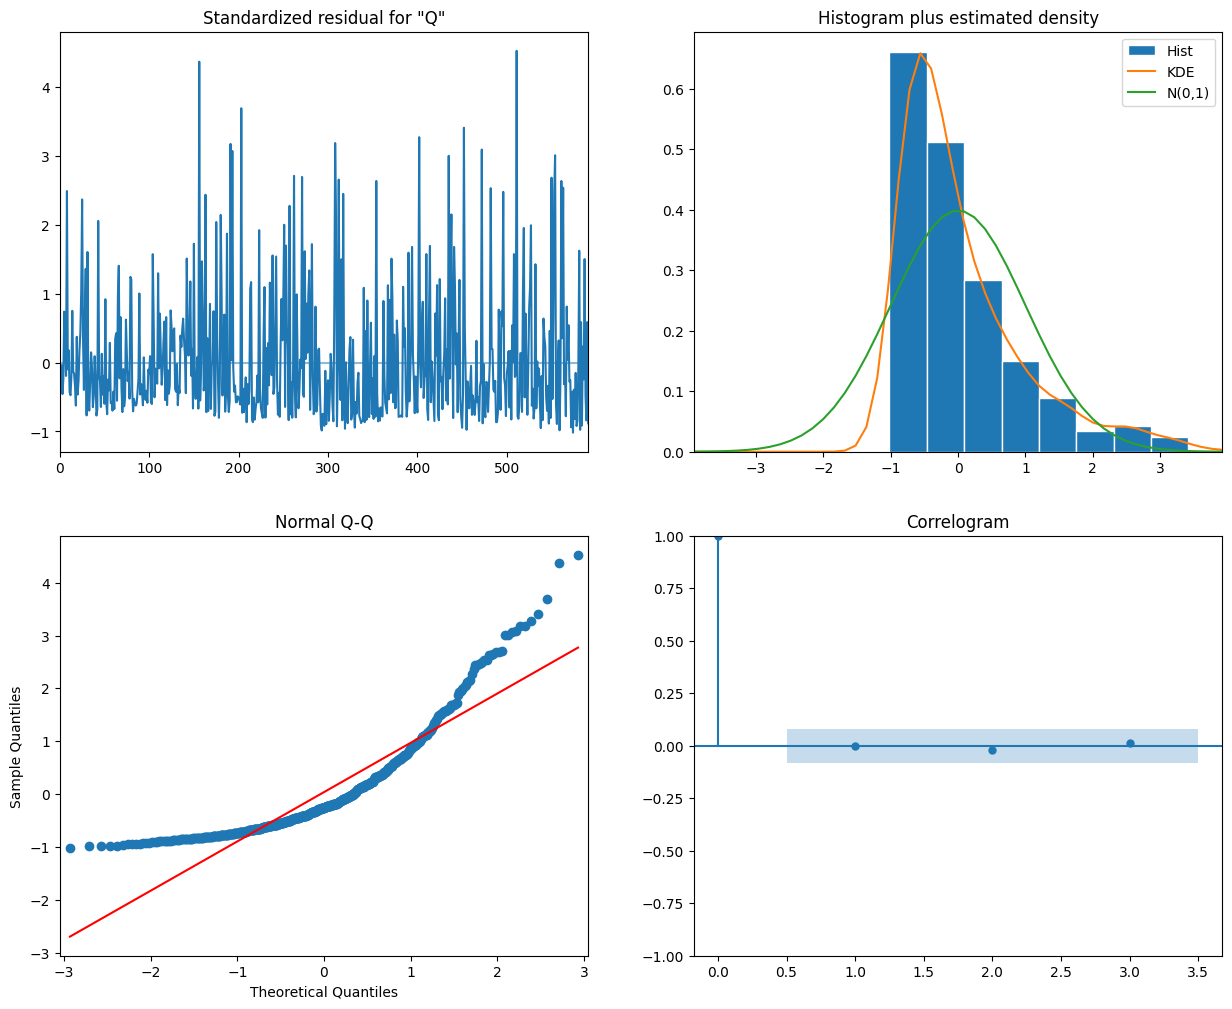

In [146]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

## **Prophet**